In [ ]:
# importing libraries
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam, Adadelta
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR

## 1. Downloading the dataset
and uploading to compressed file to drive and extracting it inside the runtime.

In [ ]:
# extracting the dataset from .tar file
!tar -xzf /content/drive/MyDrive/EE782/data/lfw.tgz

## 2. Getting the number of people having more than one image.

In [ ]:
# counting the number of files in a directory gives us the number of images for a person in this case
names, more_than_one_image = {}, 0
for name in os.listdir("/content/lfw"):
    _ = os.listdir("/content/lfw/"+name)
    if len(_) > 1:
        names[name] = (len(_), _)
        more_than_one_image += 1
print(f"No. of persons who have more than one image are: {more_than_one_image}")

No. of persons who have more than one image are: 1680


# Part-A

## 3. Splitting the dataset by "names".

In [ ]:
# 70:15:15 split for train, val, and test
train_names, val_names = train_test_split(list(names.keys()), train_size=0.7)
val_names, test_names = train_test_split(val_names, test_size=0.5)
print(f"\t\tNo. of persons\ntotal:\t\t{len(names.keys())}\ntraining:\t{len(train_names)}\nvalidation:\t{len(val_names)}\ntesting:\t{len(test_names)}")

		No. of persons
total:		1680
training:	1176
validation:	252
testing:	252


## 4. ResNet-18 pre-trained on ImageNet.

In [ ]:
resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 5. Cropping and resizing images.

In [ ]:
# cropping according to the input size required by the model, and also using image augmentations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 6. Setup and Training a Siamese Network

(a) Image augmentations have been included in the transforms defined above:

- Random Horizontal Flip
- Color Jitter

and normalization according to the ImageNet dataset statistics.

In [ ]:
# defining a custom dataset for training of the siamese model
class SiameseDataset(Dataset):
    def __init__(self, names, data, transform):
        self.names = names
        self.data = data
        self.transform = transform
        # positive represents the samples where both images are of the same person
        # taking them to have more than 5 images will help in generalization of the model
        self.positive = [name for name in self.data if self.names[name][0] > 5]
        self.pos_len = len(self.positive)

    def __len__(self):
        # positive and negative classes are balanced
        return 2*len(self.positive)

    def read_and_transform_image(self, path):
        # applying the transforms (augmentations and crops)
        img = Image.open(path)
        img = self.transform(img)
        return img

    def __getitem__(self, idx):
        # we can shuffle later in the dataloader
        # positive sample generation
        if idx < self.pos_len:
            # label: 1
            pos = torch.tensor(1)
            # name of the person
            name = self.positive[idx]
            # first two images
            img_path = [
                f"lfw/{name}/{self.names[name][1][0]}",
                f"lfw/{name}/{self.names[name][1][1]}"
                ]
        # negative sample
        else:
            # label: 0
            pos = torch.tensor(0)
            # two persons who are adjacent in the list of names
            name_1 = self.positive[idx-len(self.positive)]
            name_2 = self.positive[(idx+1)%len(self.positive)]
            # the first image of each
            img_path = [
                f"lfw/{name_1}/{self.names[name_1][1][0]}",
                f"lfw/{name_2}/{self.names[name_2][1][0]}"
                ]
        # returning the tuple of two images and the label
        img_1 = self.read_and_transform_image(img_path[0])
        img_2 = self.read_and_transform_image(img_path[1])
        return img_1, img_2, pos

In [ ]:
# siamese model class that will perform the task of finding similarity between two pictures of humans' faces
class SiameseModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x1, x2):
        return self.model(x1), self.model(x2)

    def distance(self, x1, x2):
        y1, y2 = self.forward(x1, x2)
        return F.pairwise_distance(y1, y2)

In [ ]:
# loss used is Euclidiean distance paired with hinge loss with a margin
class MetricLearningLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, y1, y2, pos):
        d = F.pairwise_distance(y1, y2)
        h_pos = torch.max(torch.tensor(0.0), d - self.margin)
        h_neg = torch.max(torch.tensor(0.0), self.margin - d)
        return torch.mean(pos * h_pos + (1 - pos) * h_neg)

In [ ]:
# generic training function with optional validation and lr scheduling
# returns the training and validation losses for every epoch as a list
def training_fn(model, optim, loss, epochs, dataloader, val=None, sched=None, verbose=False):
    validation = val is not None
    scheduler = sched is not None

    train_loss, val_loss = [], []
    for epoch in range(epochs):
        loss_curr_epoch, loss_curr_epoch_val = 0, 0
        model.train()
        for x1, x2, y in dataloader:
            x1 = x1.cuda()
            x2 = x2.cuda()
            y = y.cuda()

            optim.zero_grad()
            y1, y2 = model(x1, x2)
            loss_ = loss(y1, y2, y.float())
            loss_curr_epoch += loss_

            loss_.backward()

            optim.step()

        train_loss.append(loss_curr_epoch.item())
        if verbose: print(f"Epoch [{epoch+1}/{epochs}]\ttrain loss:{train_loss[-1]}", end="")

        if validation:
            model.eval()
            with torch.no_grad():
                for x1_val, x2_val, y_val in val:
                    x1_val = x1_val.cuda()
                    x2_val = x2_val.cuda()
                    y_val = y_val.cuda()

                    y1_val, y2_val = model(x1_val, x2_val)
                    loss_ = loss(y1_val, y2_val, y_val.float())
                    loss_curr_epoch_val += loss_

                val_loss.append(loss_curr_epoch_val.item())
            if verbose: print(f"\tval loss:{val_loss[-1]}")
        if verbose: print()

        if scheduler:
            sched.step()

    return train_loss, val_loss

In [ ]:
# instantiating the datasets and dataloaders for training, validation, and testing
dataset = {x:SiameseDataset(names, y, transform) for x, y in zip(["train", "val", "test"], [train_names, val_names, test_names])}
dataloader = {x:DataLoader(dataset[x], batch_size=32, shuffle=True) for x in ["train", "val", "test"]}

# instantiating the loss function
loss = MetricLearningLoss()
# the max number of epochs
epochs = 10

(b) L2 Regularization is already implemented in the Adamoptimizer from pytorch and the parameter is 'weight_decay', so here we are experimenting with L2 regularization.

In [ ]:
regularization = []
reg_params = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for reg_param in reg_params:
    # instantiating the base model
    model = resnet18(pretrained=True).cuda()
    # instantiating the Siamese archtiecture
    siamese_model = SiameseModel(model).cuda()

    optimizer = Adam(siamese_model.parameters(), weight_decay=reg_param)

    regularization.append(training_fn(siamese_model, optimizer, loss, epochs, dataloader["train"])[0])

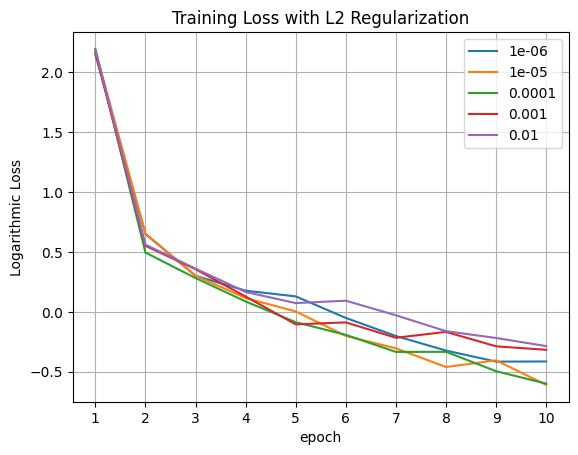

In [ ]:
# plotting the training loss curve
for i in range(len(reg_params)):
    plt.plot(range(1, epochs+1), np.log10(np.array(regularization[i])), label=reg_params[i])
plt.legend()
plt.xticks(range(1, epochs+1))
plt.xlabel("epoch")
plt.ylabel("Logarithmic Loss")
plt.title("Training Loss with L2 Regularization")
plt.grid()
plt.show()

Here, we see that as 'weight_decay' (L2 regularization parameter) decreases, the loss achieved also decreases.

We choose the value 1e-6 ( = 10 ^ -6 or 0.000001) as the parameter value for our final testing model.

## 7. LR Schedulers (Cosine and Linear)

In [ ]:
# training with cosine and liner learning rate schedulers respectively
model = resnet18(pretrained=True).cuda()
siamese_model = SiameseModel(model).cuda()
optimizer = Adam(siamese_model.parameters())
sched1 = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.001)
sched1_loss = training_fn(siamese_model, optimizer, loss, epochs, dataloader["train"], sched=sched1)[0]

model = resnet18(pretrained=True).cuda()
siamese_model = SiameseModel(model).cuda()
optimizer = Adam(siamese_model.parameters())
sched2 = LinearLR(optimizer)
sched2_loss = training_fn(siamese_model, optimizer, loss, epochs, dataloader["train"], sched=sched2)[0]

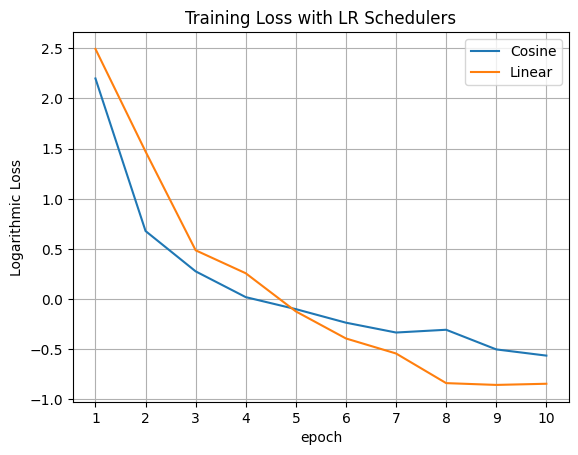

In [ ]:
# plotting the training loss curve
plt.plot(range(1, epochs+1), np.log10(np.array(sched1_loss)), label="Cosine")
plt.plot(range(1, epochs+1), np.log10(np.array(sched2_loss)), label="Linear")
plt.legend()
plt.xticks(range(1, epochs+1))
plt.xlabel("epoch")
plt.ylabel("Logarithmic Loss")
plt.title("Training Loss with LR Schedulers")
plt.grid()
plt.show()

Cosine scheduling varies the learning rate in a sinusoidal manner, so the learning rate decreases and then increases periodically along a sinusoidal curve.

Linear lr scheduler linearly interpolates from an intial to a final learning rate.

We observe that the linear lr scheduler overtakes the cosine lr scheduler and also converges to a lower loss value.

This could because the model architecutre that we have used (ResNet-18) doesn't work well with cosine lr scheduler. Choosing a learning rate scheduler that suits the task and model architecture is also an important part of training.

## 8. Optimizers (Adam and AdaDelta)

In [ ]:
# training with Adam and Adadelta respectively
model = resnet18(pretrained=True).cuda()
siamese_model = SiameseModel(model).cuda()
optim1 = Adam(siamese_model.parameters())
optim1_loss = training_fn(siamese_model, optim1, loss, epochs, dataloader["train"])[0]

model = resnet18(pretrained=True).cuda()
siamese_model = SiameseModel(model).cuda()
optim2 = Adadelta(siamese_model.parameters())
optim2_loss = training_fn(siamese_model, optim2, loss, epochs, dataloader["train"])[0]

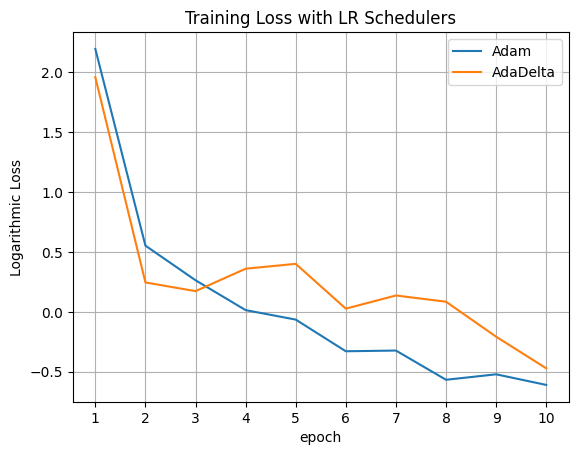

In [ ]:
# plotting the training loss curve
plt.plot(range(1, epochs+1), np.log10(np.array(optim1_loss)), label="Adam")
plt.plot(range(1, epochs+1), np.log10(np.array(optim2_loss)), label="AdaDelta")
plt.legend()
plt.xticks(range(1, epochs+1))
plt.xlabel("epoch")
plt.ylabel("Logarithmic Loss")
plt.title("Training Loss with LR Schedulers")
plt.grid()
plt.show()

Both Adam and AdaDelta use complicated mechanisms like momentum, adaptive learning rates, bias corrections, etc. for the prupose of optimization.

Optimizers are often chosen based on empirical data, and here we see tha Adam performs better than AdaDelta.

Various factors, such as the dataset, the model architecture, regularization etc determine how well an optimizer will work.

Since in our experiments Adam works better, that is what we will move forward with.

## 9. Testing

Epoch [1/10]	train loss:279.15924072265625	val loss:136.41424560546875

Epoch [2/10]	train loss:21.83087730407715	val loss:10.306665420532227

Epoch [3/10]	train loss:2.58388614654541	val loss:1.9078738689422607

Epoch [4/10]	train loss:1.8161481618881226	val loss:0.8835851550102234

Epoch [5/10]	train loss:1.0602047443389893	val loss:0.41899245977401733

Epoch [6/10]	train loss:0.4191581904888153	val loss:0.350699245929718

Epoch [7/10]	train loss:0.3556111752986908	val loss:0.17777426540851593

Epoch [8/10]	train loss:0.22846147418022156	val loss:0.0973891168832779

Epoch [9/10]	train loss:0.15184205770492554	val loss:0.14527297019958496

Epoch [10/10]	train loss:0.18209198117256165	val loss:0.09173525124788284



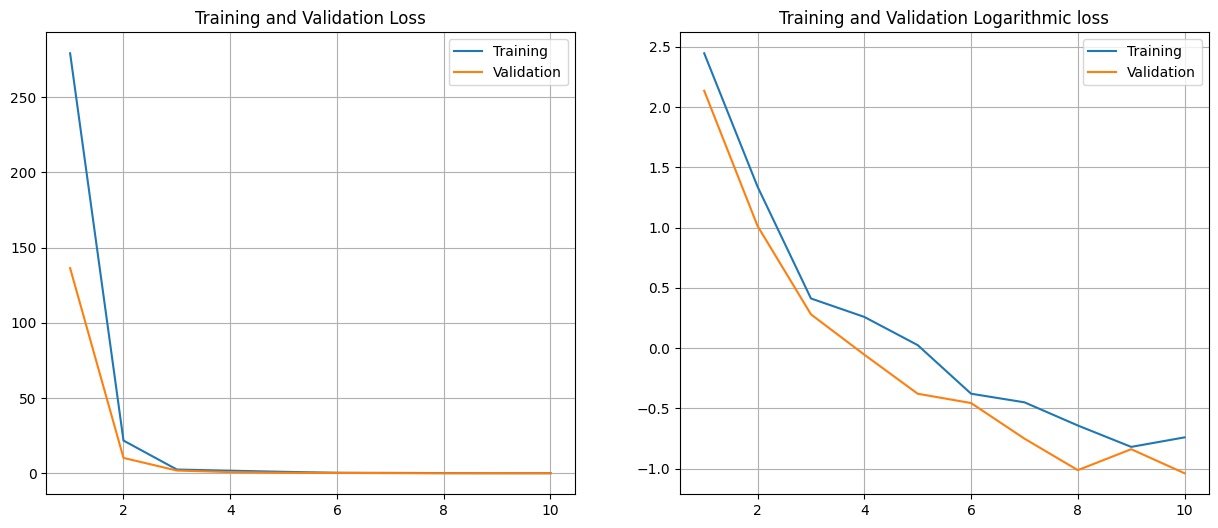

In [ ]:
# # training with the best (hopefully) parameters obtained based on above experiments
model = resnet18(pretrained=True).cuda()
siamese_model = SiameseModel(model).cuda()
optimizer = Adam(siamese_model.parameters(), weight_decay=1e-6)
scheduler = LinearLR(optimizer)
train, val = training_fn(siamese_model, optimizer, loss, epochs, dataloader["train"], val=dataloader["train"], sched=scheduler, verbose=True)

# plotting the training and validation loss and logarithmic loss curves
_, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].plot(range(1, len(train)+1), train, label="Training")
ax[0].plot(range(1, len(val)+1), val, label="Validation")
ax[0].legend()
ax[0].set_title("Training and Validation Loss")
ax[0].grid()

ax[1].plot(range(1, len(train)+1), np.log10(np.array(train)), label="Training")
ax[1].plot(range(1, len(val)+1), np.log10(np.array(val)), label="Validation")
ax[1].legend()
ax[1].set_title("Training and Validation Logarithmic loss")
ax[1].grid()
plt.show()

The validation loss is below the training loss due to taking the average in a batch and the validation set is smaller than the training set.

In [ ]:
# calculating the loss on the testing split of the dataset
test_loss = 0
siamese_model.eval()
with torch.no_grad():
    for x1, x2, y in dataloader["test"]:
        x1 = x1.cuda()
        x2 = x2.cuda()
        y = y.cuda()
        y1, y2 = siamese_model(x1, x2)
        loss_ = loss(y1, y2, y.float())
        test_loss += loss_
print(f"Total loss on the testing dataset: {test_loss}")

Total loss on the testing dataset: 0.27608364820480347


## 10. Verifying the model with local testing

In [ ]:
# preparing the images to display and the ones to give as input to the model (the input to the model shoud be normalized)
test_transform_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])
test_transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_paths = ['kanak_passport.jpeg','kanak.jpg','vaibhav.jpg','abhijeet.jpg']
imgs_display, imgs_input = [], []
for path in img_paths:
    imgs_display.append(test_transform_1(Image.open(path)))
    imgs_input.append(test_transform_2(Image.open(path)))

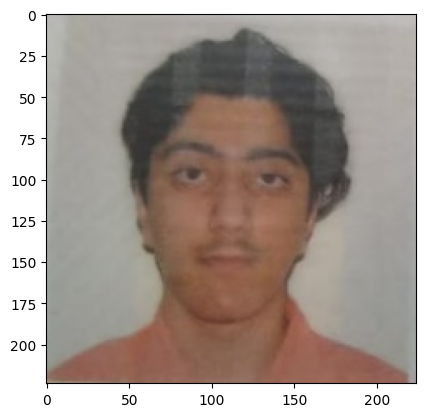

In [ ]:
# reference image
plt.imshow(imgs_display[0].permute(1, 2, 0))
plt.show()

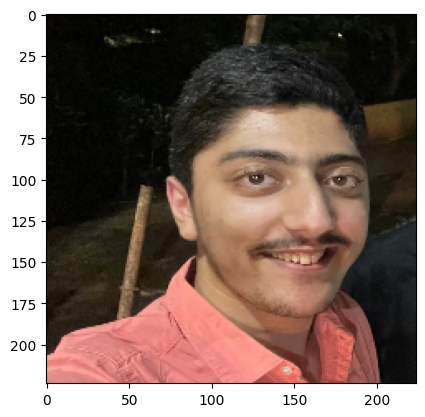

Distance: 1.0222984552383423


In [ ]:
# positive comparison
plt.imshow(imgs_display[1].permute(1, 2, 0))
plt.show()
print("Distance:", siamese_model.distance(imgs_input[0].unsqueeze(0).cuda(), imgs_input[1].unsqueeze(0).cuda()).item())

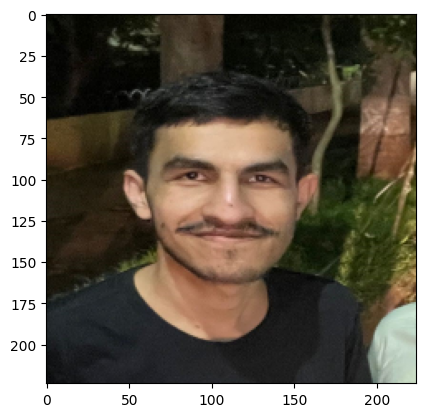

Distance: 2.3133859634399414


In [ ]:
# negative comparison
plt.imshow(imgs_display[2].permute(1, 2, 0))
plt.show()
print("Distance:", siamese_model.distance(imgs_input[0].unsqueeze(0).cuda(), imgs_input[2].unsqueeze(0).cuda()).item())

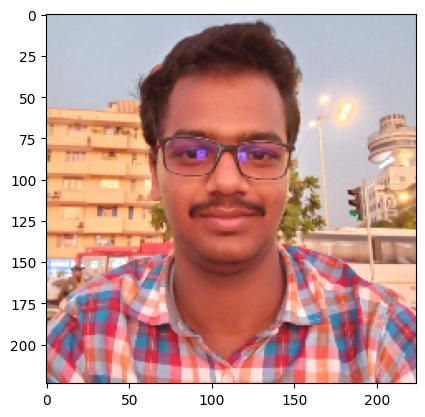

Distance: 1.8806930780410767


In [ ]:
# negative comparison
plt.imshow(imgs_display[3].permute(1, 2, 0))
plt.show()
print("Distance:", siamese_model.distance(imgs_input[0].unsqueeze(0).cuda(), imgs_input[3].unsqueeze(0).cuda()).item())

The distance between images of the same person (me) was the lowest (1.02), whereas the distance of the reference image with the images of other people was more than that (>1.88).

# Part-B

The code for GAN, CGAN and their training is adapted from:

https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs

## 11. GAN

In [ ]:
# getting the image paths and people names for datasets
img_paths = []
name_idx = {}
num_persons = 0
for name in os.listdir("/content/lfw"):
    lis = os.listdir("/content/lfw/"+name)
    if 5<=len(lis):
        [img_paths.append(f"/content/lfw/{name}/{li}") for li in lis]
        name_idx[name] = num_persons
        num_persons += 1
print(f"Total images: {len(img_paths)}")

Total images: 5985


In [ ]:
# function to display a grid of images
# source: https://pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py:~:text=%3D%20%27tight%27-,def%20show(imgs),-%3A%0A%20%20%20%20if%20not
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach().cpu()
        axs[0, i].imshow(np.asarray(img.permute(1,2,0)))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# defining a custom dataset for training of the GAN
class GAN_Dataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        img = self.transform(img)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

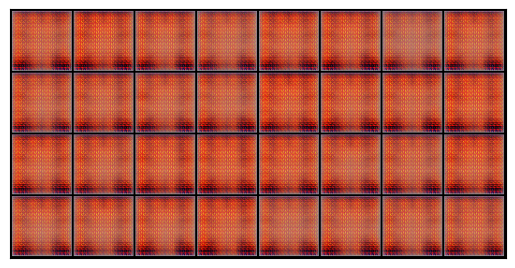

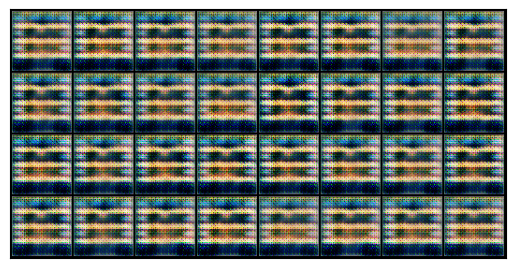

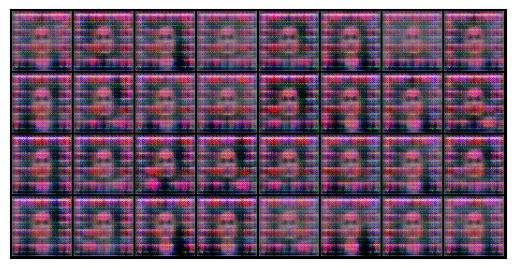

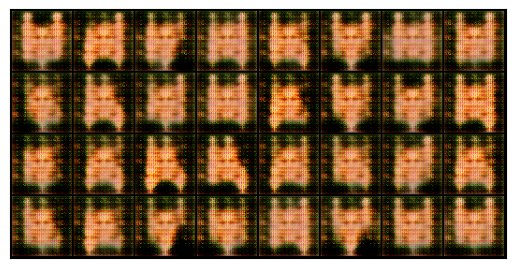

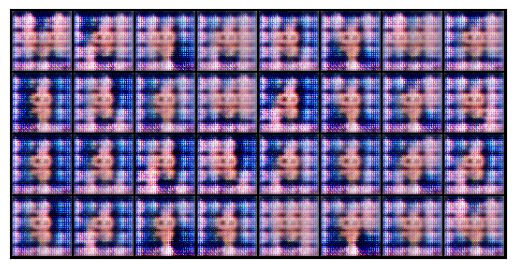

In [ ]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 512
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64
FEATURES_GEN = 64

transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*CHANNELS_IMG, [0.5]*CHANNELS_IMG),
])

dataset = GAN_Dataset(img_paths, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, real in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            fake = gen(fixed_noise)
            # take out (up to) 32 examples
            img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
            img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
            show(img_grid_fake)

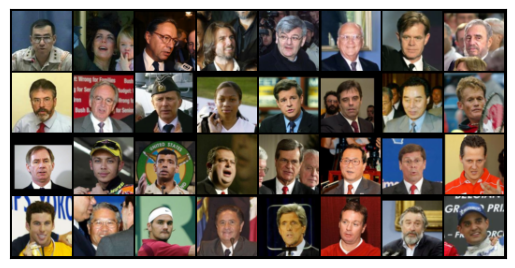

In [ ]:
show(img_grid_real)

## 12. CGAN

In [ ]:
# defining a custom dataset for training of the CGAN
class CGAN_Dataset(Dataset):
    def __init__(self, paths, transform, name_idx):
        self.paths = paths
        self.transform = transform
        self.name_idx = name_idx

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path)
        img = self.transform(img)
        return img, self.name_idx[path.split('/')[3]]

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1) # N x C x img_size (H) x img_size (W)
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        # latent vector z: N x noise_dim x 1 x 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
def gradient_penalty(critic, labels, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

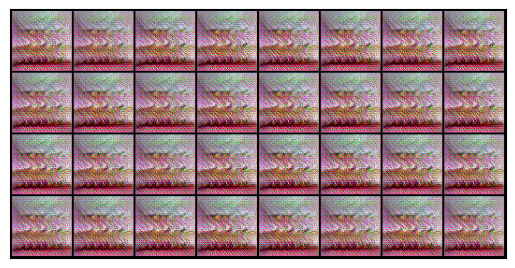

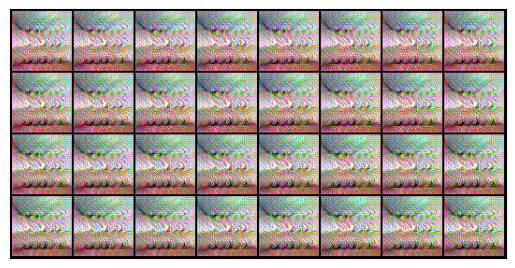

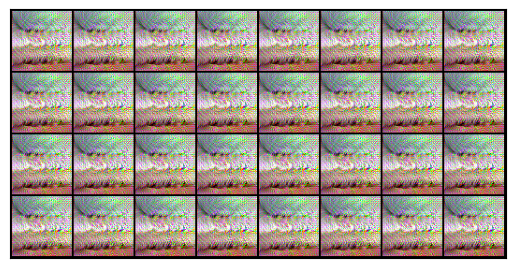

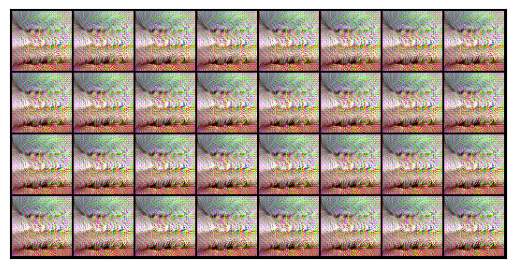

In [ ]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NUM_CLASSES = num_persons
GEN_EMBEDDING = 100
Z_DIM = 100
NUM_EPOCHS = 200
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

transforms = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*CHANNELS_IMG, [0.5]*CHANNELS_IMG),
])

dataset = CGAN_Dataset(img_paths, transforms, name_idx)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE, GEN_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
step = 0

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, labels) in enumerate(dataloader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic, labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1) + siamese_model.distance(fake, real).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    if (epoch+1) % 50 == 0:
        with torch.no_grad():
            fake = gen(noise, labels)
            # take out (up to) 32 examples
            img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
            img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
            show(img_grid_fake)

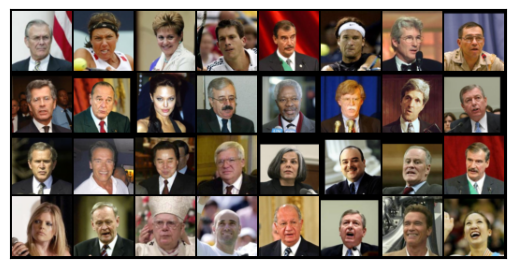

In [ ]:
show(img_grid_real)

# References:
Pretrained model
- https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

Image Augmentations, Cropping
- https://pytorch.org/vision/0.15/transforms.html

Starter Code for Training function
- ChatGPT

Optimizers, LR schedulers
- https://pytorch.org/docs/stable/index.html

Friends' Images
- Kanak Yadav (me), Vaibhav Kumar, and Abhijeet Pal

Errors
- https://discuss.pytorch.org/t/valueerror-expected-4d-input-got-3d-input/150585

GAN
- https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs

CGAN
- https://www.youtube.com/watch?v=Hp-jWm2SzR8

Visualizing GAN outputs
- https://pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py:~:text=%3D%20%27tight%27-,def%20show(imgs),-%3A%0A%20%20%20%20if%20not